# Kyaw Htet Paing Win


## TASK:

**Explore the GIS data to identify areas with high-risk of flooding in Bangladesh.**

### Task 1: Visualize the elevation data

Dataset: Shuttle Radar Topography Mission (SRTM)

*   Resolution: 30 meters

**Observations:**

*   25th & 50th percentile has the same level of elevation (11.08 meters).
*   Most of the land is flat with 95% of the area below 100 meters.

**Flood Insights:**

*   Area at or below 50th percentile most prone to flooding.

### Task 2: Visualize the land use data

Dataset: Dynamic World Land Cover
Location: [Dynamic World on Drive](https://drive.google.com/file/d/1yCAc5o_6oLyOrj-l02H45k6bx1a7GCSZ/view?usp=drive_link)

* Resolution: 10 meters

**Observations:**

* Water bodies permeate through Bangladesh.
* Notably, Bangladesh doesn't have a lot of tree and forested areas.
* Does Bangladesh really have more of snow/ice than trees?

**Flood Insights:**

* **Flooded Vegtation**: Area to pay attention to since they are already experiencing flodding. In particular, areas with high conentration of water & flooded vegetation might be most vulnerable to upcoming flood.


### Task 3: Visualize the Land Surface Temperature (Night) Celcius

Dataset: [LST by Ashique](https://drive.google.com/file/d/11ZdwI0QmFOsMDajRaaTUUkPObXx8ZqqH/view?usp=drive_link)

**Observations:**

* The Land Surface Temperature at Night follows a normal distribution

### Task 4: Compare the sand & soil water content by district

Dataset: [Sand and Soil Data from GIS static data](https://docs.google.com/spreadsheets/d/1H7zYVP4QmRq6dysTLKxdv597bn-hkok9707rGk3VxGo/edit#gid=753720457)

**Flood Insights & Recommendations:**

* **Soil water content**: If the soil is already saturated with water (from previous rainfall), its capacity to absorb more water is reduced. This can lead to increased surface runoff during heavy rains, contributing to flooding. So Moulvibazaar district for example is at risk.

* **Sand content**: Sandy soils generally have a higher infiltration rate which can reduce flooding.

* **Recommendation**: Incorporate elevation to see how the rainfall would runoff. For example, if soil water content is high and elevation is low lying then the flooding will remain in the area and will not flow down. Moreover, LandUse/LandCover also comes into play, for example, if soil water is high, elevation is low, and vegetation exists then the risk will be reduced as the vegetation can absorb the water.


In [ ]:
# !pip install geemap --quiet

In [ ]:
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [ ]:
# Authenticate the Earth Engine
ee.Authenticate()

In [ ]:
# Initialize the Earth Engine
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


In [ ]:
# Defining Bangladesh as area of interest

# Load the countries dataset and filter for Bangladesh
countries = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0')
bangladesh = countries.filter(ee.Filter.eq('ADM0_NAME', 'Bangladesh'))

# # # Get the bounding box of Bangladesh
# bbox = bangladesh.geometry().bounds()
# bbox_info = bbox.getInfo()

# # Extract the coordinates
# coordinates = bbox_info['coordinates'][0]
# lower_left = coordinates[0]  # Lower left corner
# upper_right = coordinates[2]  # Upper right corner

# # Create a Rectangle using the extracted coordinates
# bangladesh_rect = ee.Geometry.Rectangle([lower_left[0], lower_left[1], upper_right[0], upper_right[1]])

# Directly use the geometry of the feature and simplify it
bangladesh_polygon = bangladesh.geometry().simplify(maxError=ee.ErrorMargin(1, 'meters'))

In [ ]:
"""
  TASK 1: Preparing for elevation mapping
"""
# Load the SRTM elevation data
elevation = ee.Image('CGIAR/SRTM90_V4')

# Compute percentiles of elevation
percentiles = elevation.reduceRegion(
    reducer=ee.Reducer.percentile([25, 50, 75, 95, 99]),
    geometry=bangladesh,
    scale=30,  # scale in meters
    maxPixels=1e9
)

# Extract the percentile values and print them
percentile_values = percentiles.getInfo()
print('25th percentile:', percentile_values['elevation_p25'])
print('50th percentile:', percentile_values['elevation_p50'])
print('75th percentile:', percentile_values['elevation_p75'])
print('95th percentile:', percentile_values['elevation_p95'])
print('99th percentile:', percentile_values['elevation_p99'])

# Define colors
colors = ['#ff0000', '#ff0000', '#ffbfbf', '#bfffca', '#00af50']

# Create a legend labels with color palette
legend_labels = {
    f"25th Percentile ({round(percentile_values['elevation_p25'], 1)}m)" : colors[0],
    f"50th Percentile ({round(percentile_values['elevation_p50'], 1)}m)" : colors[1],
    f"75th Percentile ({round(percentile_values['elevation_p75'], 1)}m)" : colors[2],
    f"95th Percentile ({round(percentile_values['elevation_p95'], 1)}m)" : colors[3],
    f"99th Percentile ({round(percentile_values['elevation_p99'], 1)}m)" : colors[4],
}

# Setting visualization params for elevation data
vis_params = {
    # Range of elevation by min & max
    'min': 0, 'max': round(percentile_values['elevation_p99'], 0) + 50,
    'palette': colors,
}

25th percentile: 11.084782671487066
50th percentile: 11.084782671487066
75th percentile: 27.13994609481494
95th percentile: 99.44434982194385
99th percentile: 323.5305030269429


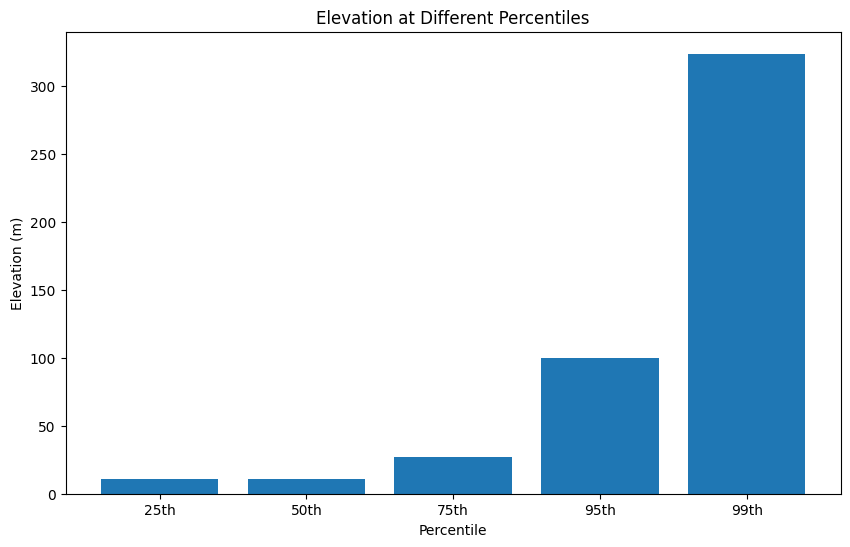

In [ ]:
# Task 1: Visualizing the elevation percentile
percentiles = ['25th', '50th', '75th', '95th', '99th']
elevation_values = [percentile_values['elevation_p25'], percentile_values['elevation_p50'], percentile_values['elevation_p75'], percentile_values['elevation_p95'], percentile_values['elevation_p99']]
# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(percentiles, elevation_values)

# Adding titles and labels
plt.title('Elevation at Different Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Elevation (m)')

# Display the plot
plt.show()

In [ ]:
"""
  TASK 2: Land Cover/Land Use
"""
# Define the land cover type and corresponding colors
# Dynamic World has nine land types
# According to this site: I found the following label
# https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#bands
land_cover_type = {
    0: "Water",
    1: "Flooded vegetation",
    2: "Built-up areas",
    3: "Trees",
    4: "Crops",
    5: "Bare ground",
    6: "Grass",
    7: "Shrub/scrub",
    8: "Snow/ice"
}
land_cover_colors = ['#419bdf', '#397d49', '#88b053', '#7a87c6', '#e49635', '#dfc35a', '#c4281b', '#a59b8f', '#b39fe1']

land_cover_legend = {v: land_cover_colors[k] for k, v in land_cover_type.items()}

# Load the Dynamic World land cover dataset for Bangladesh
land_cover = ee.Image('projects/ee-kyawhtetpaingwin111/assets/DynamicWorld_Bangladesh_Jan_2023')

# Setting visualization parameters for land cover
land_vis_params = {'min': 0, 'max': 8, 'palette': land_cover_colors}

In [ ]:
land_cover.getInfo()

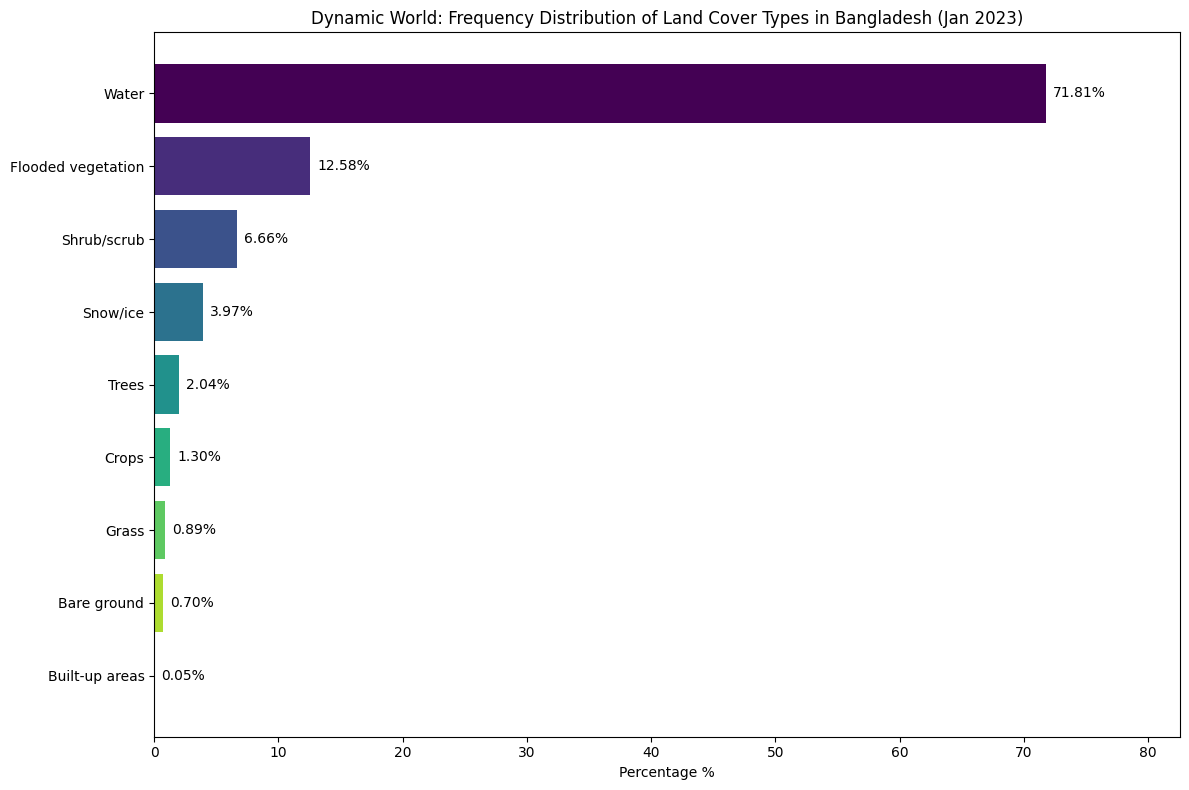

In [ ]:
"""
  TASK 2: Land Cover Distribution Breakdown
"""
clipped_land_cover = land_cover.clip(bangladesh_polygon)

# Calculate the frequency of each land cover type for the entire dataset
frequency = land_cover.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    scale=10,
    maxPixels=1e10
).getInfo()

# Assuming the frequency is for the first band
frequency = frequency['b1']

frequency = {int(k):v for k,v in frequency.items()}

# Convert frequencies to percentages and sort by percentage
total_pixels = sum(frequency.values())
percentages = {land_cover_type[k]: (v / total_pixels) * 100 for k, v in frequency.items()}
sorted_percentages = dict(sorted(percentages.items(), key=lambda item: item[1], reverse=True))

# Extract labels and values for plotting
labels = list(sorted_percentages.keys())
values = list(sorted_percentages.values())

# Create the color gradient based on values
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size

bars = ax.barh(labels, values, color=colors)
ax.set_xlabel('Percentage %')
ax.set_title('Dynamic World: Frequency Distribution of Land Cover Types in Bangladesh (Jan 2023)')

# Annotate bars with percentages on the right side
for bar, value in zip(bars, values):
    text = f"{value:.2f}%"
    ax.annotate(text, xy=(value, bar.get_y() + bar.get_height() / 2), xytext=(5, 0),
                textcoords="offset points", ha='left', va='center')

# Invert y-axis for correct order
ax.invert_yaxis()

# Set the x-axis limit to accommodate the longest label
x_lim = ax.get_xlim()[1]
buffer = max(values) * 0.1  # 10% of the max value
ax.set_xlim(0, x_lim + buffer)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
"""
Task 3: Visualize the Land Surface Temperature at Night
"""

# Load the LST asset from Google Earth Engine
asset_location = 'projects/ee-kyawhtetpaingwin111/assets/lst_night_celcius'
lst_data = ee.Image(asset_location)

# Specify the region
region = lst_data.geometry()

# Compute the stats of the temperature
stats = lst_data.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=region,
    scale=30, # TODO: Is this really the pixel resolution
    maxPixels= 1e9
)

print(stats.getInfo())

# Extract the min and max values
min_lst = stats.getInfo()['b1_min']
max_lst = stats.getInfo()['b1_max']

print(f'Min Lst: {min_lst}')
print(f"Max Lst: {max_lst}")

# Define visualization parameters
lst_vis_params = {
    'min': min_lst,
    'max': max_lst,
    'palette': ['#0000FF', '#00FF00', '#FFFF00', '#FF0000']  # blue, green, yellow, red
}

lst_legend_dict = {
    'Cold': '#0000FF',
    'Moderate': '#00FF00',
    'Warm': '#FFFF00',
    'Hot': '#FF0000'
}


{'b1_max': 31.84000000000002, 'b1_min': 24.147777777777815}
Min Lst: 24.147777777777815
Max Lst: 31.84000000000002


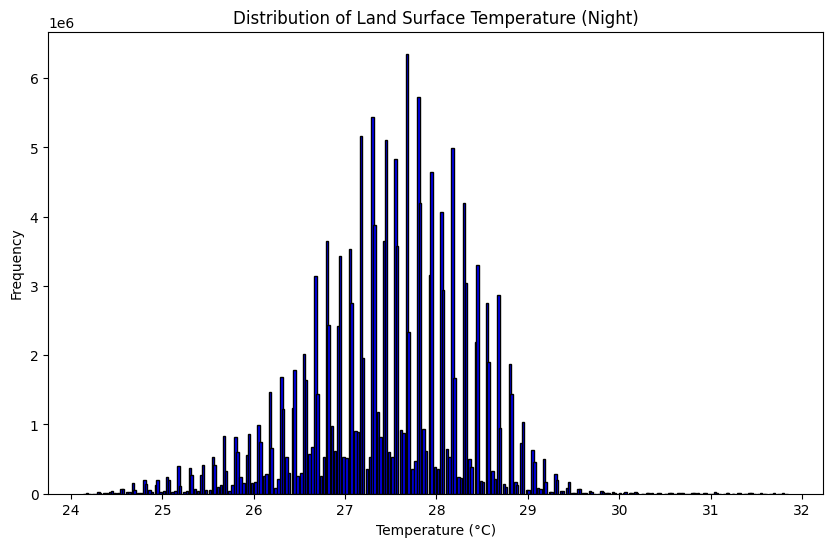

In [ ]:
# Find the band names
#print(f"Band Names: {lst_data.bandNames().getInfo()}")

# Use reduceRegion with a histogram reducer
histogram_result = lst_data.reduceRegion(
    reducer=ee.Reducer.histogram(),
    geometry=region,
    scale=30,  # Adjust the scale to a suitable value
    maxPixels=1e9
).getInfo()

# Assuming 'b1' is the correct band name
histogram = histogram_result['b1']

# The histogram reducer returns a dictionary with 'histogram' and 'bucketMeans'
# Extract values for plotting (bucket means and frequencies)
bucket_means = histogram['bucketMeans']
frequencies = histogram['histogram']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bucket_means, frequencies, width=np.diff(bucket_means)[0], color='blue', edgecolor='black')
plt.title('Distribution of Land Surface Temperature (Night)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Create a map
Map = geemap.Map(center=(23.6850, 90.3563), zoom=7)

# Land Cover Layer
Map.addLayer(clipped_land_cover, land_vis_params, 'Land Cover')
# Elevation Layer
Map.addLayer(elevation.clip(bangladesh_polygon), vis_params, "SRTM Elevation")
# LST Layer
Map.addLayer(lst_data, lst_vis_params, 'Land Surface Temp (C) Night')

# Adding legends
Map.add_legend(title="Elevation Percentiles", legend_dict=legend_labels)
Map.add_legend(title="Land Cover Type", legend_dict=land_cover_legend)
Map.add_legend(title="Land Surface Temperature Night (C)", legend_dict=lst_legend_dict)

Map.addLayerControl()

# Display the map
Map

Map(center=[23.685, 90.3563], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### TASK 4: Sand Content & Soil Water Content Analysis

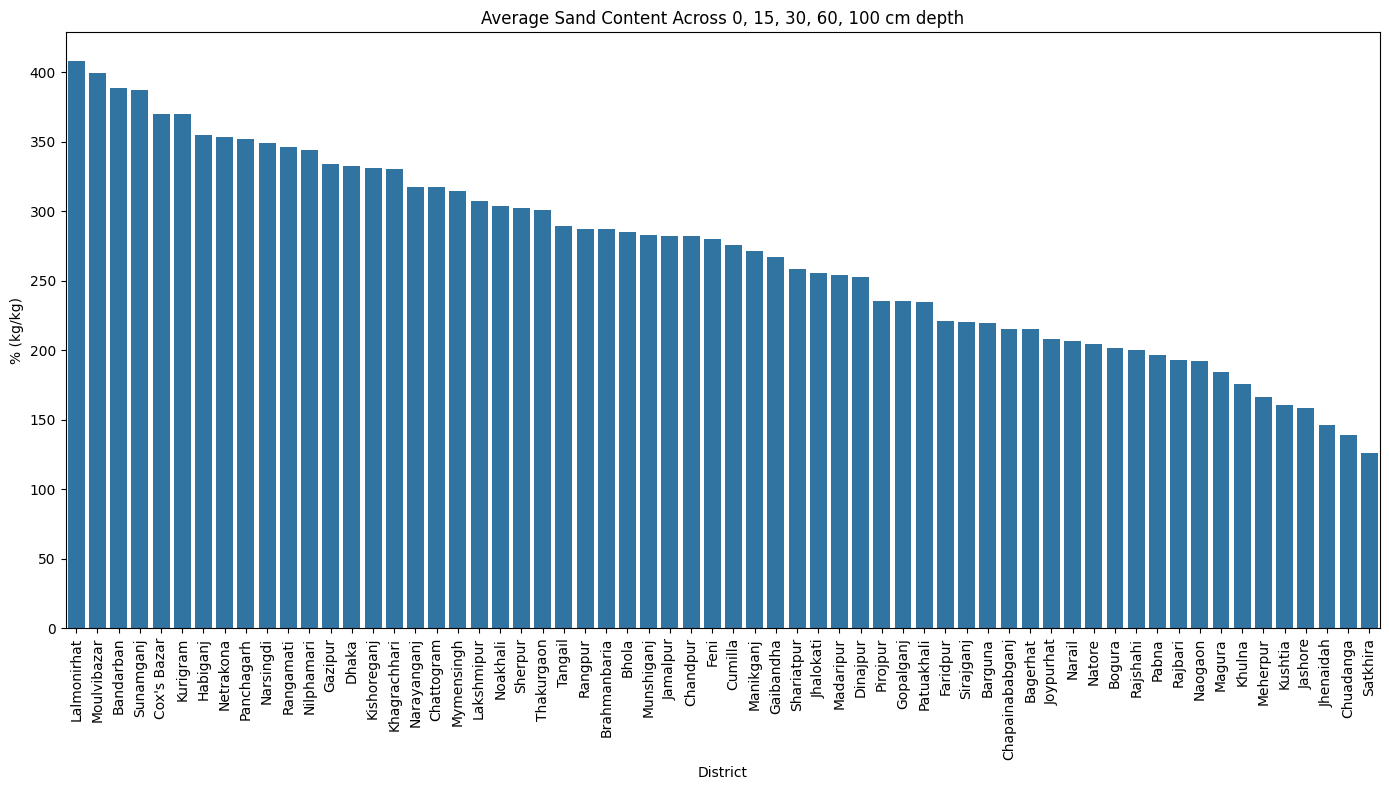

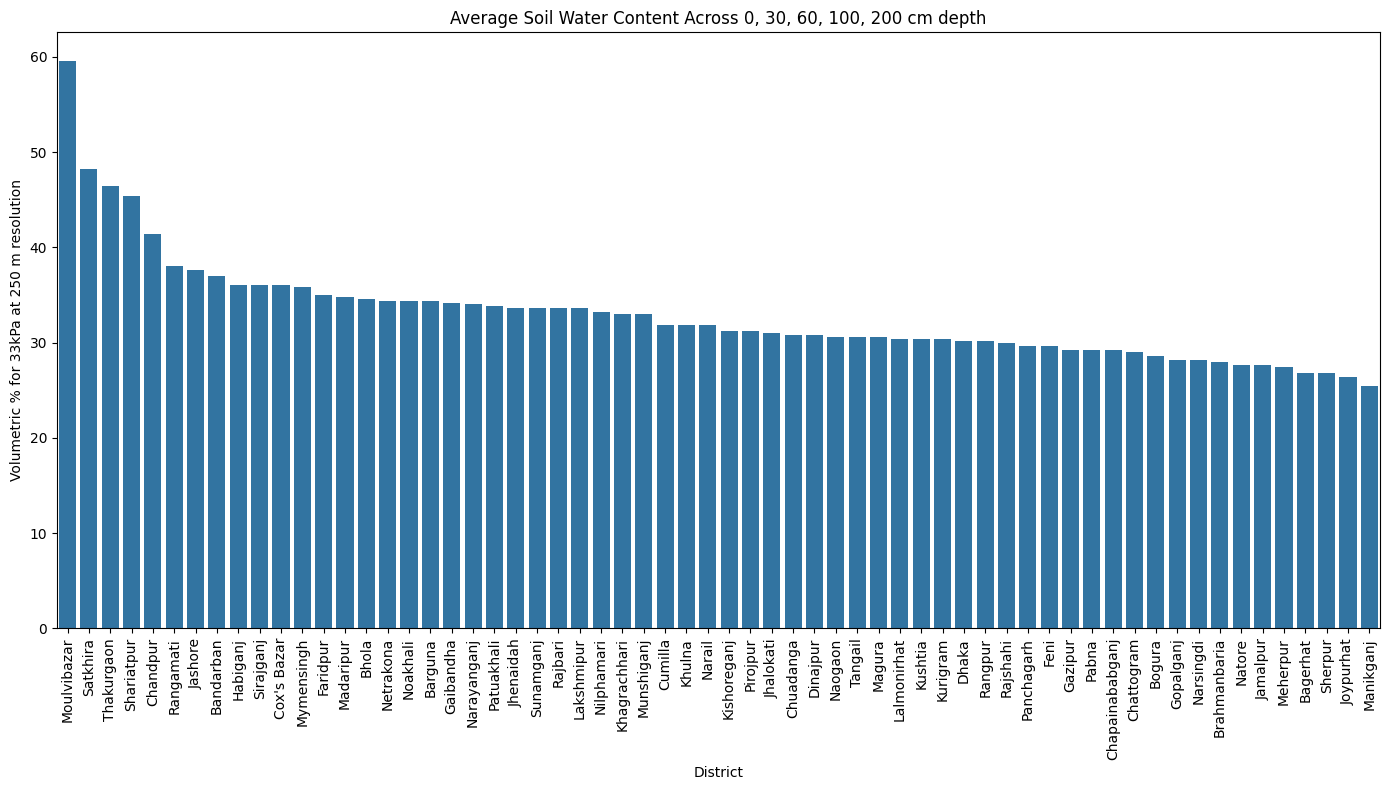

In [ ]:
import os
csv_file_path = '/content/drive/MyDrive/GIS Data Analysis/Bangladesh GIS Data Exploration/Sand_Soil_Content.csv'
# Reading the CSV file into a DataFrame
sand_soil_data = pd.read_csv(csv_file_path)

# Drop rows with NaN values to ensure accurate calculations
sand_soil_data.dropna(inplace=True)

# Calculate mean sand content for each district at different depths
district_sand_mean = sand_soil_data.set_index('District')[[col for col in sand_soil_data.columns if 'Sand' in col]].mean(axis=1)

# Calculate mean soil water content for each district at different suction pressures
district_soil_water_mean = sand_soil_data.set_index('District')[[col for col in sand_soil_data.columns if 'SoilWaterContent' in col]].mean(axis=1)

# Sort the values from largest to smallest
sorted_sand_content = district_sand_mean.sort_values(ascending=False)
sorted_soil_water_content = district_soil_water_mean.sort_values(ascending=False)

# Define a single solid color for the bars
bar_color = '#1f77b4'

# Create vertical bar charts for sorted sand and soil water content
plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_sand_content.index, y=sorted_sand_content.values, color=bar_color)
plt.title('Average Sand Content Across 0, 15, 30, 60, 100 cm depth')
plt.ylabel('% (kg/kg)')
plt.xlabel('District')
plt.xticks(rotation=90)  # Rotate district names for better readability

plt.tight_layout()
folder = '/content/drive/MyDrive/GIS Data Analysis/Bangladesh GIS Data Exploration'
pic_path = os.path.join(folder, 'district_sand_content.png')
plt.savefig(pic_path)

# plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_soil_water_content.index, y=sorted_soil_water_content.values, color=bar_color)
plt.title('Average Soil Water Content Across 0, 30, 60, 100, 200 cm depth')
plt.ylabel('Volumetric % for 33kPa at 250 m resolution')
plt.xlabel('District')
plt.xticks(rotation=90)  # Rotate district names for better readability

plt.tight_layout()
pic_path = os.path.join(folder, 'district_soil_water_content.png')
plt.savefig(pic_path)

# plt.show()